In [ ]:
!pip install tensorflow-io
!pip install pydub
!apt-get install ffmpeg -y


In [ ]:
!apt-get update
!apt-get install -y ffmpeg libavcodec-extra


In [43]:
import os
import math
import random
import zipfile
import requests
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow.keras import layers
from tensorflow.keras import models
from DataUtils.DownloadCapuchin import download_dataset,parse_datasets
from IPython import display
from matplotlib import pyplot as plt
from pydub import AudioSegment, effects
from pydub.generators import WhiteNoise
from multiprocessing.pool import ThreadPool

In [44]:
capuchin_files = os.listdir("Parsed_Capuchinbird_Clips")
not_capuchin_files = os.listdir("Parsed_Not_Capuchinbird_Clips")
Capuchin_File = "XC3776-6.wav" #random.choice(capuchin_files)
Not_Capuchin_File = random.choice(not_capuchin_files)
print(f"Displaying {Capuchin_File} which is an example of a Parsed Capuchinbird Call:")
display.display(display.Audio(os.path.join("Parsed_Capuchinbird_Clips",Capuchin_File)))
print(f"Displaying {Not_Capuchin_File} which is an example of a Parsed Other Noise:")
display.display(display.Audio(os.path.join("Parsed_Not_Capuchinbird_Clips",Not_Capuchin_File)))

Displaying XC3776-6.wav which is an example of a Parsed Capuchinbird Call:


Displaying dove-bird-sounds-6.wav which is an example of a Parsed Other Noise:


In [45]:
def Add_White_Noise(sound, decibels = 50):
    noise = WhiteNoise().to_audio_segment(duration=len(sound))-decibels
    combined = sound.overlay(noise)
    return combined
def Normalize_Volume(sound):
    normalized_sound = effects.normalize(sound)
    return normalized_sound
def Filter_Out_High_Frequency(sound,cutoff = 8e3):
    filtered_sound = effects.low_pass_filter(sound,cutoff)
    return filtered_sound
def Filter_Out_Low_Frequency(sound,cutoff = 8e3):
    filtered_sound = effects.high_pass_filter(sound,cutoff)
    return filtered_sound

In [46]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary,desired_channels=1,)
    return tf.squeeze(audio, axis=-1)
def get_label(file_path):
    parts = tf.strings.split(
        input=file_path,
        sep=os.path.sep)
    return parts[-2]
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [47]:
def get_spectrogram(waveform):
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
    [16000] - tf.shape(waveform),
    dtype=tf.float32)

    waveform = tf.cast(waveform, dtype=tf.float32)

    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
    equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [48]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    return output_ds

In [49]:
seed = 1842
tf.random.set_seed(seed)
np.random.seed(seed)

warnings.simplefilter('ignore')

In [50]:
data_dir = os.getcwd()
commands = ["Parsed_Capuchinbird_Clips","Parsed_Not_Capuchinbird_Clips"]
filenames_Capuchinbird = tf.io.gfile.glob(str(data_dir) + '/Parsed_Capuchinbird_Clips/*')
filenames_Not_Capuchinbird = tf.io.gfile.glob(str(data_dir) + '/Parsed_Not_Capuchinbird_Clips/*')
filenames =tf.concat([filenames_Capuchinbird, filenames_Not_Capuchinbird], 0)
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)

Number of total examples: 810


In [51]:
train_split = int(.8*num_samples)
val_split = int(.1*num_samples)
test_split = num_samples - train_split - val_split
train_files = filenames[:train_split]
val_files = filenames[train_split: train_split + val_split]
test_files = filenames[-1*test_split:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 648
Validation set size 81
Test set size 81


In [52]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

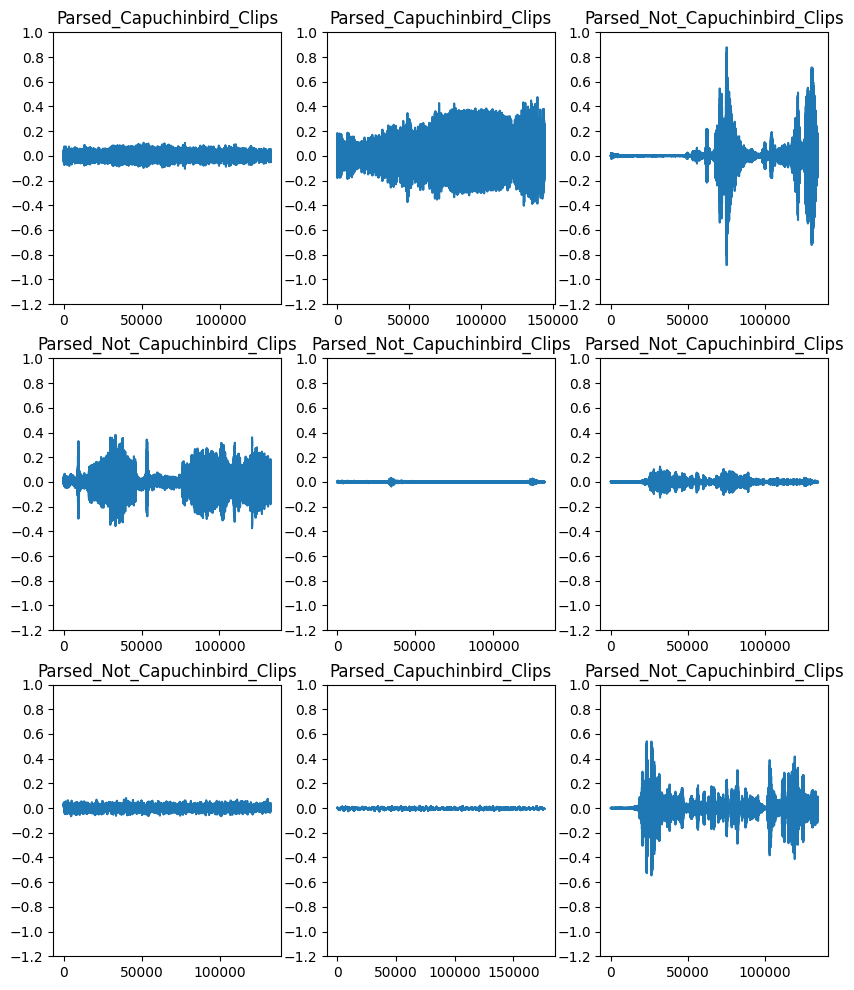

In [53]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

In [54]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: Parsed_Capuchinbird_Clips
Waveform shape: (132300,)
Spectrogram shape: (124, 129, 1)
Audio playback


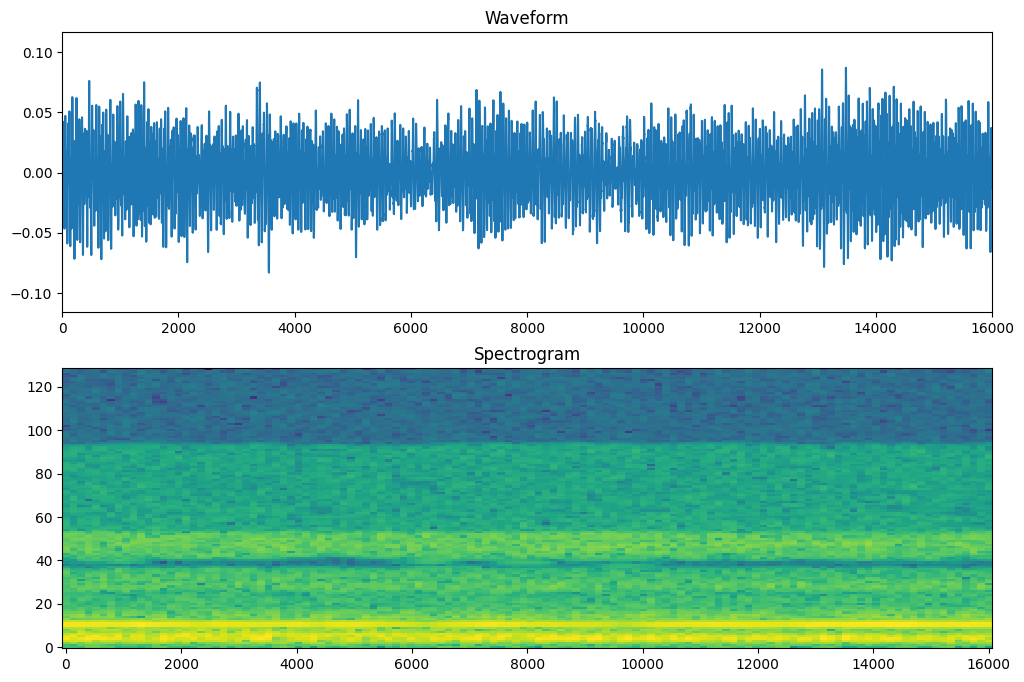

In [55]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [56]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

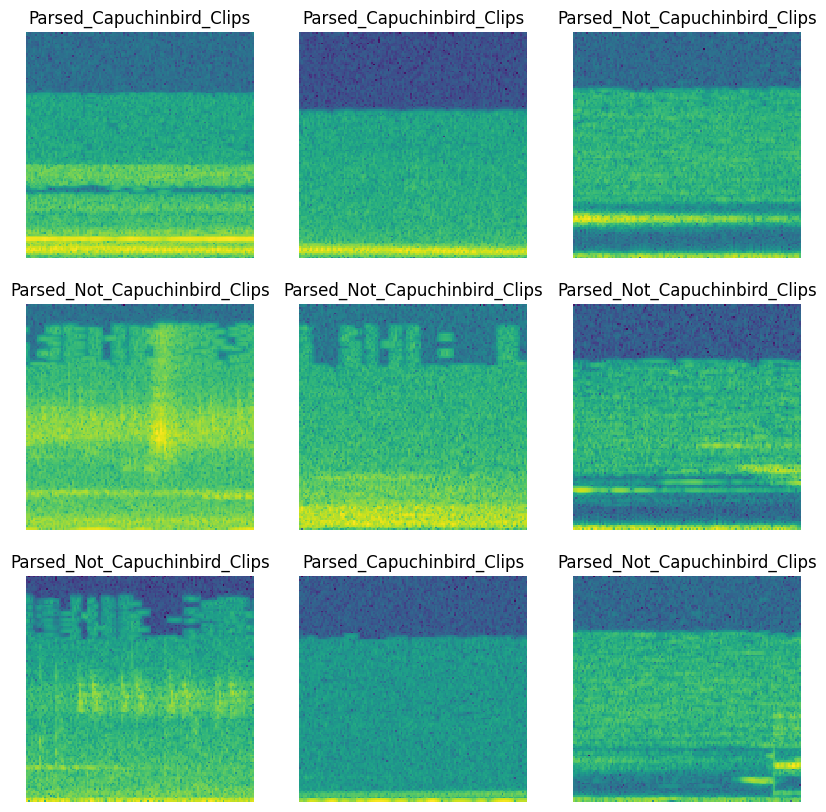

In [57]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

### Build and Train Model

In [58]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [59]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = layers.Normalization()

norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

cnn_model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Resizing(32, 32),

    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

cnn_model.summary()

Input shape: (124, 129, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_1 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,624,837 (6.20 MB)

 Trainable params: 1,624,834 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [60]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [61]:
EPOCHS = 20
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1,
                                               patience=5,
                                               restore_best_weights=True
                                              ),
)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 426ms/step - accuracy: 0.6496 - loss: 0.6174 - val_accuracy: 0.7778 - val_loss: 0.4227
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.8099 - loss: 0.4067 - val_accuracy: 0.8395 - val_loss: 0.3457
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.8527 - loss: 0.3292 - val_accuracy: 0.8395 - val_loss: 0.3068
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 289ms/step - accuracy: 0.8999 - loss: 0.2632 - val_accuracy: 0.8765 - val_loss: 0.2612
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.9191 - loss: 0.2203 - val_accuracy: 0.8642 - val_loss: 0.2973
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.9216 - loss: 0.1971 - val_accuracy: 0.8395 - val_loss: 0.2742
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.9037 - loss: 0.2236 - val_accuracy: 0.8642 - val_loss: 0.2399
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.9192 - loss: 0.1790 - val_accuracy: 0.

### Investigate Model Performance

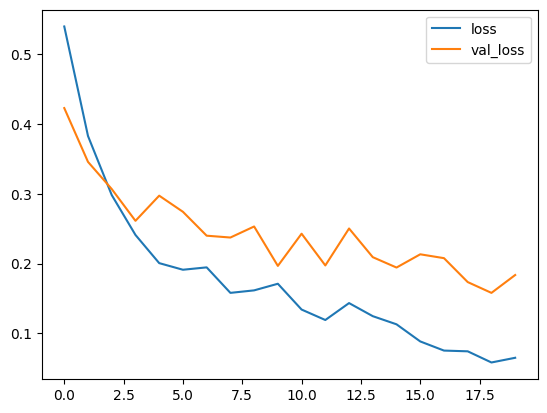

In [62]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [63]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(cnn_model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Test set accuracy: 95%


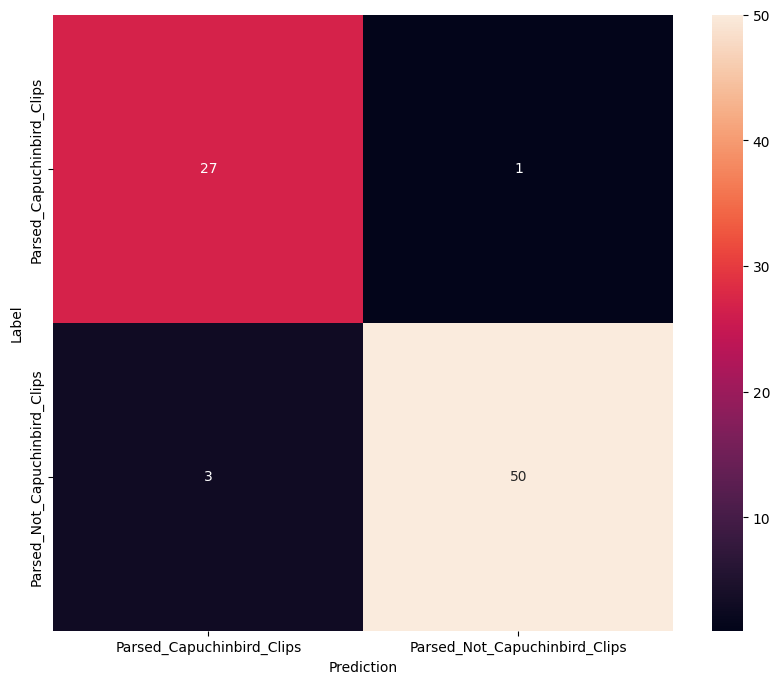

In [64]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

XC395129-5.wav


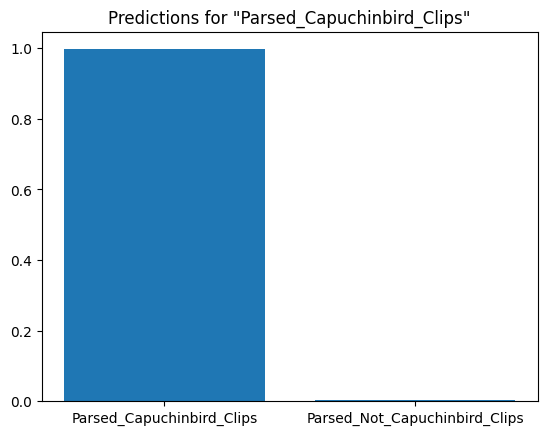

In [65]:
capuchin_files = os.listdir("Parsed_Capuchinbird_Clips")
sample_file = random.choice(capuchin_files)
print(sample_file)
sample_ds = preprocess_dataset([os.path.join("Parsed_Capuchinbird_Clips",sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = cnn_model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()

In [66]:
@tf.function
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav
def load_wav_for_map(filename, label):
    return load_wav_16k_mono(filename), label
def extract_embedding(wav_data, label):
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings)
           )
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    if shuffle:

        ds = ds.shuffle(shuffle_size, seed=1842)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

tf.get_logger().setLevel('ERROR')

### Download YAMNet pretrained model

In [67]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [68]:
capuchin_files = os.listdir("Parsed_Capuchinbird_Clips")
capuchin = []
for file in capuchin_files:
    if file.endswith('.wav'):
        capuchin.append(os.path.join("Parsed_Capuchinbird_Clips",file))
not_capuchin_files = os.listdir("Parsed_Not_Capuchinbird_Clips")
not_capuchin = []
for file in not_capuchin_files:
    if file.endswith('.wav'):
        not_capuchin.append(os.path.join("Parsed_Not_Capuchinbird_Clips",file))

In [69]:
capuchin_pd = pd.DataFrame({"filename":capuchin,"target":1})
not_capuchin_pd = pd.DataFrame({"filename":not_capuchin,"target":0})
dataset_pd = pd.concat([capuchin_pd,not_capuchin_pd],axis=0,ignore_index=True)
dataset_pd

,filename,target
0,Parsed_Capuchinbird_Clips/XC27882-3.wav,1
1,Parsed_Capuchinbird_Clips/XC433953-8.wav,1
2,Parsed_Capuchinbird_Clips/XC216012-6.wav,1
3,Parsed_Capuchinbird_Clips/XC388470-3.wav,1
4,Parsed_Capuchinbird_Clips/XC79965-0.wav,1
...,...,...
805,Parsed_Not_Capuchinbird_Clips/crickets-chirpin...,0
806,Parsed_Not_Capuchinbird_Clips/robin-chirping-3...,0
807,Parsed_Not_Capuchinbird_Clips/crickets-sound-e...,0
808,Parsed_Not_Capuchinbird_Clips/Crickets-chirpin...,0


In [70]:
main_ds = tf.data.Dataset.from_tensor_slices((dataset_pd["filename"], dataset_pd["target"]))
main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [71]:
# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [72]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(main_ds,len(dataset_pd))

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

### Build Model

In [73]:
yamnet_transfer_learning_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
], name='yamnet_transfer_learning_model')

yamnet_transfer_learning_model.summary()

Model: "yamnet_transfer_learning_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,826 (2.01 MB)

 Trainable params: 525,826 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
yamnet_transfer_learning_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

### Train Model

In [75]:
history = yamnet_transfer_learning_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.8226 - loss: 0.3857 - val_accuracy: 0.9012 - val_loss: 0.2474
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9679 - loss: 0.1253 - val_accuracy: 0.9012 - val_loss: 0.2365
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9739 - loss: 0.0849 - val_accuracy: 0.9383 - val_loss: 0.1583
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9816 - loss: 0.0662 - val_accuracy: 0.9506 - val_loss: 0.1342
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9946 - loss: 0.0386 - val_accuracy: 0.9506 - val_loss: 0.1248
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9968 - loss: 0.0278 - val_accuracy: 0.9506 - val_loss: 0.1121
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9960 - loss: 0.0237 - val_accuracy: 0.9630 - val_loss: 0.1088
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9975 - loss: 0.0203 - val_accuracy: 0.9630 - val_lo

### Investigate Model Performance

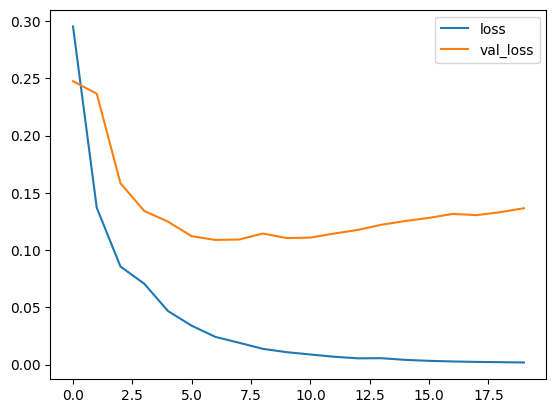

In [76]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [77]:
loss, accuracy = yamnet_transfer_learning_model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

135/135 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.9781 - loss: 0.0818
Loss:  0.08762411773204803
Accuracy:  0.9740740656852722


In [78]:
def locations_to_approx_seconds(location):
    return str(location*3)
def locations_to_approx_result_row(location):
    return str(int(location*6.5))
def make_tests(capuchin_path,not_capuchin_path,capuchin_count):
    seconds = 1000
    capuchin_sound = AudioSegment.from_wav(capuchin_path)
    not_capuchin_sound = AudioSegment.from_wav(not_capuchin_path)
    total_clips = 60
    locations = random.sample(range(1, total_clips), capuchin_count)
    locations.sort()
    clip_positions = ",".join(map(str,locations))
    approx_locations_sec = ",".join(map(locations_to_approx_seconds,locations))
    approx_locations_result_row = ",".join(map(locations_to_approx_result_row,locations))
    print(f"Capuchin Calls are Located at [{clip_positions}] positions in the clip")
    print(f"Capuchin Calls are Located around [{approx_locations_sec}] seconds in the clip")
    print(f"Capuchin Calls are Located around [{approx_locations_result_row}] in the result rows")
    clips = []
    for i in range(total_clips):
        if i in locations:
            clips.append(capuchin_sound)
        else:
            test = random.sample([0,1],1)
            if test == 0:
                clips.append(WhiteNoise().to_audio_segment(duration=len(3*1000)))
            else:
                clips.append(not_capuchin_sound)
    final_clip = clips[0]
    for i in range(1,len(clips)):
        final_clip = final_clip + clips[i]
    output_file = "test.wav"
    final_clip.export(output_file, format="wav")
    return output_file

In [79]:
capuchin_files = os.listdir("Parsed_Capuchinbird_Clips")
not_capuchin_files = os.listdir("Parsed_Not_Capuchinbird_Clips")
Capuchin_File = random.choice(capuchin_files)
Not_Capuchin_File = random.choice(not_capuchin_files)
Num_Capuchin_Calls = 5
print(f"Using {Capuchin_File} and {Not_Capuchin_File} to generate {Num_Capuchin_Calls} Capuchinbird Calls")

not_capuchin_path = os.path.join("Parsed_Not_Capuchinbird_Clips",Not_Capuchin_File)
capuchin_path = os.path.join("Parsed_Capuchinbird_Clips",Capuchin_File)
test_file_name = make_tests(capuchin_path,not_capuchin_path,Num_Capuchin_Calls)

Using XC65196-4.wav and forest-birds-and-insects-sound-effect-4.wav to generate 5 Capuchinbird Calls
Capuchin Calls are Located at [14,18,35,42,49] positions in the clip
Capuchin Calls are Located around [42,54,105,126,147] seconds in the clip
Capuchin Calls are Located around [91,117,227,273,318] in the result rows


In [80]:
testing_wav_data = load_wav_16k_mono(test_file_name)
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = yamnet_transfer_learning_model(embeddings).numpy()
result

array([[  7.081875  ,  -7.348068  ],
       [  7.994362  ,  -8.265259  ],
       [  8.410806  ,  -8.433035  ],
       [  6.806548  ,  -6.805173  ],
       [ 17.822594  , -15.94111   ],
       [  5.0977087 ,  -4.8835816 ],
       [  3.3182902 ,  -2.7293477 ],
       [  7.9678345 ,  -8.026657  ],
       [  7.6197615 ,  -7.860005  ],
       [  7.1468596 ,  -6.948963  ],
       [  4.098408  ,  -4.2204256 ],
       [ 14.310983  , -12.8355665 ],
       [  5.0134616 ,  -4.5487924 ],
       [  3.951305  ,  -3.3732398 ],
       [  8.351639  ,  -8.297328  ],
       [  9.020458  ,  -9.256985  ],
       [  8.560188  ,  -8.502146  ],
       [  4.106857  ,  -3.8090158 ],
       [ 12.839727  , -11.7630825 ],
       [  3.785745  ,  -3.3117566 ],
       [  6.8335094 ,  -6.838501  ],
       [  8.873422  ,  -8.947029  ],
       [  7.25476   ,  -7.420661  ],
       [  6.6262164 ,  -6.8050056 ],
       [ 15.926927  , -14.5836    ],
       [  5.6651583 ,  -5.3644867 ],
       [  4.223025  ,  -3.5622468 ],
 

In [81]:
count = 0
previous_pos = 0
capuchin_count = 0
print("Embeddings with Positive Val for Capuchinbird Call:")
for row in result:
    if row[1]>0:
        if count - previous_pos > 1:
            capuchin_count += 1
        previous_pos = count
        value = '%.2f' % round(row[1],2)
        if count <100:
            print(f"  row:  {count} value: {value}")
        else:
            print(f"  row: {count} value: {value}")
    count += 1
print(f"Found {capuchin_count} of {Num_Capuchin_Calls} Capuchin Calls!")

Embeddings with Positive Val for Capuchinbird Call:
  row:  93 value: 1.41
  row:  94 value: 5.38
  row:  95 value: 7.74
  row:  96 value: 6.91
  row:  97 value: 3.96
  row:  98 value: 3.46
  row:  99 value: 1.86
  row: 121 value: 7.23
  row: 122 value: 4.97
  row: 123 value: 8.16
  row: 124 value: 7.48
  row: 125 value: 7.88
  row: 126 value: 1.78
  row: 235 value: 0.83
  row: 236 value: 3.71
  row: 237 value: 7.49
  row: 238 value: 7.69
  row: 239 value: 3.06
  row: 240 value: 5.69
  row: 283 value: 4.76
  row: 284 value: 5.93
  row: 285 value: 8.43
  row: 286 value: 6.09
  row: 287 value: 5.34
  row: 288 value: 3.48
  row: 289 value: 2.38
  row: 331 value: 4.44
  row: 332 value: 5.57
  row: 333 value: 8.12
  row: 334 value: 12.72
  row: 335 value: 5.34
  row: 336 value: 2.11
Found 5 of 5 Capuchin Calls!


In [82]:
clip_names = os.listdir("Forest Recordings")
clip_names.sort()
counts = [0]*len(clip_names) # Change with your scores
submission_df = pd.DataFrame({"clip_name":clip_names,"call_count":counts})
submission_df.to_csv("submission.csv",index=False)
submission_df

,clip_name,call_count
0,recording_00.mp3,0
1,recording_01.mp3,0
2,recording_02.mp3,0
3,recording_03.mp3,0
4,recording_04.mp3,0
...,...,...
95,recording_95.mp3,0
96,recording_96.mp3,0
97,recording_97.mp3,0
98,recording_98.mp3,0


In [85]:
!ls


 Challenge_3_Final.ipynb      Other_Sound_Urls.csv		   README.md
'Challenge 3 Template.csv'    Parsed_Capuchinbird_Clips		   requirements.txt
'Challenge 3 Template.xlsx'   Parsed_Not_Capuchinbird_Clips	   sample_data
 DataUtils		      Parsing_Single_Call_Timestamps.csv   submission.csv
'Forest Recordings'	      Raw_Capuchinbird_Clips		   test.wav
 my_data.zip		      Raw_Not_Capuchinbird_Clips
